In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import os
import cv2
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset

In [ ]:


class HollowKnightActionDataset(Dataset):
    def __init__(
        self,
        root_dir,
        video_file='Hollow Knight - Hornet fight.mp4',
        annotation_file='annotations.xml',
        transform=None,
        target_size=(64, 64),
        key_frame=None
    ):
        self.root_dir = root_dir
        self.video_path = os.path.join(root_dir, video_file)
        self.transform = transform
        self.target_size = target_size

        tree = ET.parse(os.path.join(root_dir, annotation_file))
        root = tree.getroot()

        labels = set()
        for track in root.findall('.//track'):
            labels.add(track.attrib['label'])

        self.classes = sorted(labels)
        self.class_to_id = {c: i for i, c in enumerate(self.classes)}

        self.samples = []
        for track in root.findall('.//track'):
            label = track.attrib['label']
            label_id = self.class_to_id[label]

            for box in track.findall('box'):
                if box.attrib.get('outside') == '1':
                    continue

                frame_id = int(box.attrib['frame'])

                xtl = float(box.attrib['xtl'])
                ytl = float(box.attrib['ytl'])
                xbr = float(box.attrib['xbr'])
                ybr = float(box.attrib['ybr'])

                self.samples.append({
                    'frame': frame_id,
                    'bbox': (xtl, ytl, xbr, ybr),
                    'label': label_id
                })

        self.samples.sort(key=lambda x: x['frame'])

        if key_frame is not None:
            self.samples = self.samples[:key_frame]

        self.cap = cv2.VideoCapture(self.video_path)
        assert self.cap.isOpened(), 'Failed to open video'

        print('[Dataset] Classes:', self.classes)
        print('[Dataset] Samples:', len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        frame_idx = sample['frame']
        x1, y1, x2, y2 = map(int, sample['bbox'])
        label = sample['label']

        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = self.cap.read()
        if not ret:
            return torch.zeros((3, *self.target_size)), label

        h, w, _ = frame.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            crop = frame

        crop = cv2.resize(crop, self.target_size)
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

        if self.transform:
            crop = self.transform(image=crop)['image']
        else:
            crop = torch.from_numpy(crop).permute(2, 0, 1).float() / 255.0

        return crop, label


In [104]:
from collections import Counter
dataset = HollowKnightActionDataset(root_dir='dataset_root')
print(Counter([y for _, y in dataset]))


[Dataset] Classes: ['hornet_drill', 'hornet_ram', 'hornet_silk', 'hornet_throw']
[Dataset] Samples: 1266
Counter({0: 475, 3: 387, 1: 213, 2: 191})


In [105]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1,  bias=False)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.down_sample = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.down_sample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
                
            )

    def forward(self, x):
        identity = x
        if self.down_sample is not None:
            identity = self.down_sample(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out)
        # 2 слой
        out = self.conv2(out)
        out = self.batch2(out)
        # должны быть одинаковые размеры
        out += identity
        out = self.relu(out)
        return out

In [106]:
class CustomLightNet(nn.Module):
    def __init__(self, num_clusses=21):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.LeakyReLU(inplace=True)
        self.basic1 = ResidualBlock(16, 16)
        self.basic2 = ResidualBlock(16, 16) 

        self.basic3 = ResidualBlock(16, 32, stride=2)
        self.basic4 = ResidualBlock(32, 32, stride=1) 

        self.basic5 = ResidualBlock(32, 64, stride=2)
        self.basic6 = ResidualBlock(64, 64, stride=1) 

        self.basic7 = ResidualBlock(64, 128, stride=2)
        self.basic8 = ResidualBlock(128, 128, stride=1) 

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        #  Dropout
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(128, num_clusses)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.relu((self.bn1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic4(self.basic3(out))
        out = self.basic6(self.basic5(out))
        out = self.basic8(self.basic7(out))
        
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        
        out = self.dropout(out)
        
        out = self.fc(out)
        return out

In [107]:
import json


In [ ]:
train_transform = A.Compose([
    # A.HorizontalFlip(p=0.5), # Для Хорнет аккуратнее с флипом, если атаки зависят от стороны
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


full_dataset = HollowKnightActionDataset(
    root_dir='dataset_root',
    video_file='Hollow Knight - Hornet fight.mp4',
    annotation_file='annotations.xml',
    transform=train_transform,
    key_frame=8000
)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True 
)
from collections import Counter
print(Counter([y for _, y in full_dataset]))
print(full_dataset.classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")
if device.type == 'cuda':
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")


model = CustomLightNet(num_clusses=5) 
model = model.to(device)

[Dataset] Classes: ['hornet_drill', 'hornet_ram', 'hornet_silk', 'hornet_throw']
[Dataset] Samples: 1266
Train size: 1012, Val size: 254
Counter({0: 475, 3: 387, 1: 213, 2: 191})
['hornet_drill', 'hornet_ram', 'hornet_silk', 'hornet_throw']
Используется устройство: cuda
Имя GPU: NVIDIA GeForce RTX 4060 Ti


Примеры кропов из тренировочной выборки:


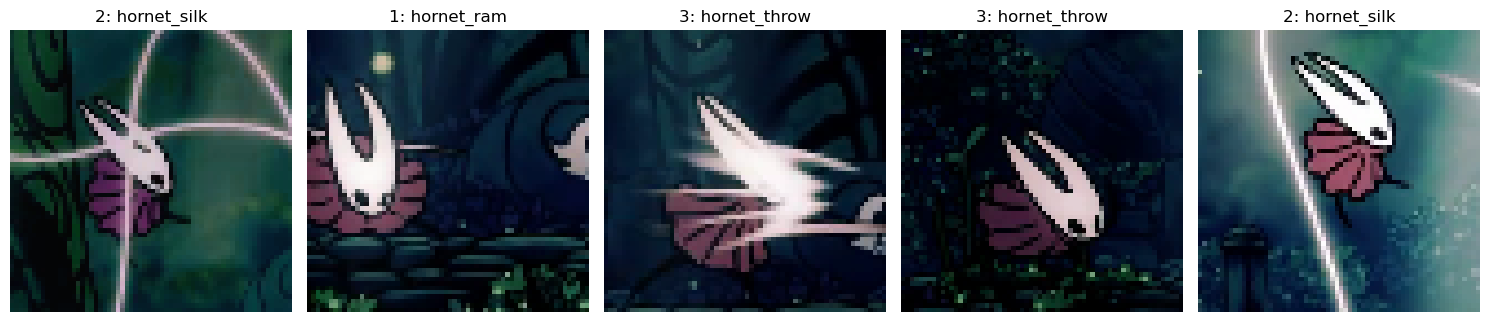

In [ ]:
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    # Tensor (C, H, W) -> Numpy (H, W, C)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def show_classified_crops(dataloader, class_names=None, count=5, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    images, labels = next(iter(dataloader))
    
    n_images = min(count, len(images))
    
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    

    if n_images == 1: axes = [axes]
        
    for i in range(n_images):
        img = denormalize(images[i], mean, std)
        label_idx = labels[i].item()
        
        if class_names and label_idx < len(class_names):
            title = f"{label_idx}: {class_names[label_idx]}"
        else:
            title = f"Class: {label_idx}"
            
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = full_dataset.classes 

print("Примеры кропов из тренировочной выборки:")
show_classified_crops(train_loader, class_names=class_names, count=5)

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import os

def train_action_classifier(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, save_path='best_action_model.pth', use_mixup=False, mixup_alpha=0.2):
    model = model.to(device)

    history = {
        'loss_train': [],
        'acc_train': [],
        'loss_val': [],
        'acc_val': []
    }
    

    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # MIXUP 
            if use_mixup and mixup_alpha > 0:

                lam = np.random.beta(mixup_alpha, mixup_alpha)

                index = torch.randperm(images.size(0)).to(device)
                mixed_images = lam * images + (1 - lam) * images[index, :]

                output = model(mixed_images)
                
                y_a, y_b = labels, labels[index]
                loss = lam * criterion(output, y_a) + (1 - lam) * criterion(output, y_b)
                
                _, predicted = torch.max(output.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
            else:
                # Обычное обучение
                output = model(images)
                loss = criterion(output, labels)
                
                _, predicted = torch.max(output.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total
        
        history['loss_train'].append(avg_train_loss)
        history['acc_train'].append(avg_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                output = model(images)
                loss = criterion(output, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / val_total
        
        history['loss_val'].append(avg_val_loss)
        history['acc_val'].append(avg_val_acc)

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_acc) 
            else:
                scheduler.step()

        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            torch.save(model.state_dict(), save_path)
            saved_msg = f"-> Model Saved! ({best_acc:.4f})"
        else:
            saved_msg = ""


        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f} {saved_msg}')
        print('-' * 80)
        
    return model, history

In [113]:
model_ResNet = model
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer_ResNet = torch.optim.AdamW(model_ResNet.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 20
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ResNet, 
    mode='max', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

In [114]:
trained_model_ResNet, history_ResNet = train_action_classifier(
    model=model_ResNet,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer_ResNet,
    scheduler=scheduler,
    epochs=epochs,
    device=device
)

Epoch 1/20: 100%|██████████| 32/32 [01:26<00:00,  2.70s/it, loss=0.641]


Epoch [1/20] Train Loss: 1.1768 | Train Acc: 0.6729 | Val Loss: 1.2346 | Val Acc: 0.8268 -> Model Saved! (0.8268)
--------------------------------------------------------------------------------


Epoch 2/20: 100%|██████████| 32/32 [01:27<00:00,  2.74s/it, loss=0.633]


Epoch [2/20] Train Loss: 0.6768 | Train Acc: 0.9200 | Val Loss: 0.9025 | Val Acc: 0.8740 -> Model Saved! (0.8740)
--------------------------------------------------------------------------------


Epoch 3/20: 100%|██████████| 32/32 [01:26<00:00,  2.70s/it, loss=0.77] 


Epoch [3/20] Train Loss: 0.5613 | Train Acc: 0.9585 | Val Loss: 0.5001 | Val Acc: 0.9724 -> Model Saved! (0.9724)
--------------------------------------------------------------------------------


Epoch 4/20: 100%|██████████| 32/32 [01:23<00:00,  2.62s/it, loss=0.611]


Epoch [4/20] Train Loss: 0.5465 | Train Acc: 0.9634 | Val Loss: 0.4708 | Val Acc: 0.9961 -> Model Saved! (0.9961)
--------------------------------------------------------------------------------


Epoch 5/20: 100%|██████████| 32/32 [01:24<00:00,  2.64s/it, loss=0.48] 


Epoch [5/20] Train Loss: 0.4931 | Train Acc: 0.9872 | Val Loss: 0.4433 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 6/20: 100%|██████████| 32/32 [01:24<00:00,  2.63s/it, loss=0.519]


Epoch [6/20] Train Loss: 0.4770 | Train Acc: 0.9960 | Val Loss: 0.4361 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 7/20: 100%|██████████| 32/32 [01:24<00:00,  2.64s/it, loss=0.477]


Epoch [7/20] Train Loss: 0.4684 | Train Acc: 0.9911 | Val Loss: 0.4422 | Val Acc: 0.9921 
--------------------------------------------------------------------------------


Epoch 8/20: 100%|██████████| 32/32 [01:23<00:00,  2.62s/it, loss=0.475]


Epoch [8/20] Train Loss: 0.4572 | Train Acc: 0.9990 | Val Loss: 0.4931 | Val Acc: 0.9646 
--------------------------------------------------------------------------------


Epoch 9/20: 100%|██████████| 32/32 [01:25<00:00,  2.66s/it, loss=0.47] 


Epoch [9/20] Train Loss: 0.4590 | Train Acc: 0.9980 | Val Loss: 0.4406 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 10/20: 100%|██████████| 32/32 [01:26<00:00,  2.72s/it, loss=0.482]


Epoch [10/20] Train Loss: 0.4527 | Train Acc: 0.9990 | Val Loss: 0.4595 | Val Acc: 0.9803 
--------------------------------------------------------------------------------


Epoch 11/20: 100%|██████████| 32/32 [01:26<00:00,  2.71s/it, loss=0.478]


Epoch [11/20] Train Loss: 0.4460 | Train Acc: 1.0000 | Val Loss: 0.4336 | Val Acc: 0.9921 
--------------------------------------------------------------------------------


Epoch 12/20: 100%|██████████| 32/32 [01:24<00:00,  2.64s/it, loss=0.441]


Epoch [12/20] Train Loss: 0.4397 | Train Acc: 0.9990 | Val Loss: 0.4205 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 13/20: 100%|██████████| 32/32 [01:24<00:00,  2.64s/it, loss=0.429]


Epoch [13/20] Train Loss: 0.4351 | Train Acc: 0.9990 | Val Loss: 0.4267 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 14/20: 100%|██████████| 32/32 [01:23<00:00,  2.61s/it, loss=0.453]


Epoch [14/20] Train Loss: 0.4364 | Train Acc: 1.0000 | Val Loss: 0.4199 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 15/20: 100%|██████████| 32/32 [01:23<00:00,  2.61s/it, loss=0.44] 


Epoch [15/20] Train Loss: 0.4348 | Train Acc: 1.0000 | Val Loss: 0.4212 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 16/20: 100%|██████████| 32/32 [01:26<00:00,  2.70s/it, loss=0.421]


Epoch [16/20] Train Loss: 0.4353 | Train Acc: 0.9980 | Val Loss: 0.4448 | Val Acc: 0.9803 
--------------------------------------------------------------------------------


Epoch 17/20: 100%|██████████| 32/32 [01:26<00:00,  2.70s/it, loss=0.418]


Epoch [17/20] Train Loss: 0.4327 | Train Acc: 1.0000 | Val Loss: 0.4156 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 18/20: 100%|██████████| 32/32 [01:31<00:00,  2.85s/it, loss=0.422]


Epoch [18/20] Train Loss: 0.4265 | Train Acc: 1.0000 | Val Loss: 0.4185 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


Epoch 19/20: 100%|██████████| 32/32 [01:24<00:00,  2.63s/it, loss=0.44] 


Epoch [19/20] Train Loss: 0.4280 | Train Acc: 0.9990 | Val Loss: 0.4269 | Val Acc: 0.9921 
--------------------------------------------------------------------------------


Epoch 20/20: 100%|██████████| 32/32 [01:23<00:00,  2.62s/it, loss=0.416]


Epoch [20/20] Train Loss: 0.4265 | Train Acc: 1.0000 | Val Loss: 0.4183 | Val Acc: 0.9961 
--------------------------------------------------------------------------------


In [115]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader

def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Обратное преобразование нормализации для отображения"""
    mean = np.array(mean)
    std = np.array(std)
    # Tensor (C, H, W) -> Numpy (H, W, C)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

In [116]:
def show_classified_crops(dataloader, model, class_names, device, count=5, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):

    model.eval()
    images, labels = next(iter(dataloader))
    with torch.no_grad():
        images_cuda = images.to(device) 
        outputs = model(images_cuda)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu() 
    
    n_images = min(count, len(images))
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    
    if n_images == 1: axes = [axes]
        
    for i in range(n_images):
        img = denormalize(images[i].cpu(), mean, std)
        
        true_idx = labels[i].item()
        pred_idx = preds[i].item()
        true_text = class_names[true_idx]
        pred_text = class_names[pred_idx]
        color = 'green' if true_idx == pred_idx else 'red'
        
        title = f"True: {true_text}\nPred: {pred_text}"
            
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize=10, color=color)
        axes[i].axis('off')
        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.show()

In [117]:
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"Start evaluation on {len(loader.dataset)} samples...")

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n" + "="*50)
    print("Classification Report (Precision, Recall, F1-Score per class):")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    print("="*50)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d',   
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names 
    )
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

Примеры кропов из валидационной выборки с предсказаниями


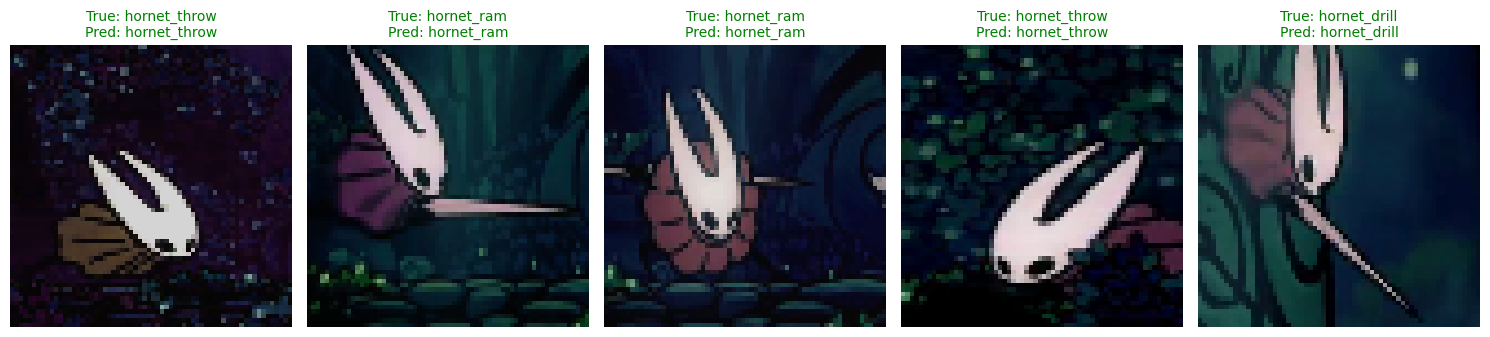

In [118]:
print("Примеры кропов из валидационной выборки с предсказаниями")
show_classified_crops(
    dataloader=val_loader, 
    model=trained_model_ResNet, 
    class_names=class_names, 
    device=device, 
    count=5 
)
#

Детальная статистика по классам
Start evaluation on 254 samples...


Evaluating: 100%|██████████| 8/8 [00:20<00:00,  2.50s/it]


Classification Report (Precision, Recall, F1-Score per class):
              precision    recall  f1-score   support

hornet_drill     0.9894    1.0000    0.9947        93
  hornet_ram     1.0000    1.0000    1.0000        43
 hornet_silk     1.0000    0.9762    0.9880        42
hornet_throw     1.0000    1.0000    1.0000        76

    accuracy                         0.9961       254
   macro avg     0.9973    0.9940    0.9957       254
weighted avg     0.9961    0.9961    0.9960       254



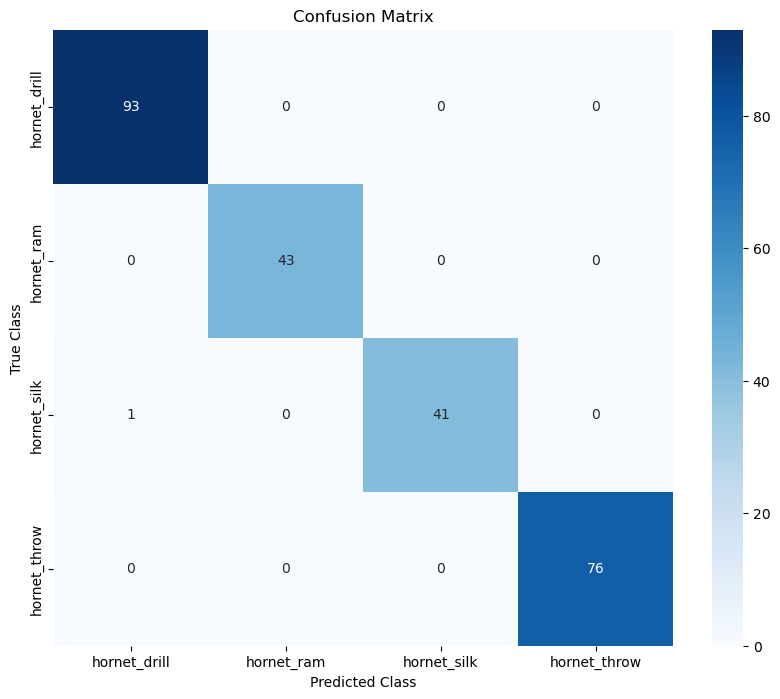

In [119]:
print("Детальная статистика по классам")
evaluate_model(
    model=trained_model_ResNet, 
    loader=val_loader, 
    device=device, 
    class_names=class_names
)
#